Pre-Processing and model building.
Authors: Julie Ng, Neha Sindhu

In [1]:
from google.colab import files
uploaded = files.upload()

Saving combined_dataframe.xlsx to combined_dataframe.xlsx


In [5]:
import pandas as pd

df = pd.read_excel('~/Documents/BINF/competition/combined_dataframe.xlsx')
print(df.shape)
df.head()

(207, 42)


,Participant_ID,Sex,Age (Years),Race,Baseline eGFR (ml/min/1.73m2),Proteinuria (mg) (Binned),A1c (%) (Binned),Albuminuria (mg) (Binned),Diabetes History,Diabetes Duration (Years),...,Potassium (mEq/L),Chloride (mEq/L),Calcium (mg/dL),Cystatin C (mg/L),Urine Creatinine (mg/dL),Urine Albumin (mg/dL),Urine Protein (mg/dL),ACR (mg/g),PCR (mg/g),Creatinine_Index_mgkgday
0,27-10039,Female,60-69 Years,White,44.833049,NaN,>=8.5%,500 to <1000 mg/g cr,Yes,30-34 Years,...,4.4,101.0,9.5,2.03522,42.9,19.00,34.0,442.89000,792.540000,11.508197
1,27-10041,Female,60-69 Years,Asian,60.392502,NaN,>=8.5%,30 to <300 mg/g cr,Yes,25-29 Years,...,4.5,100.0,10.1,1.73246,19.8,1.84,15.0,92.93000,757.580000,8.583318
2,27-10042,Female,50-59 Years,White,36.830792,NaN,>=8.5%,30 to <300 mg/g cr,Yes,25-29 Years,...,4.2,104.0,9.2,1.66518,36.1,2.54,11.0,70.36000,304.710000,11.990392
3,27-10043,Female,40-49 Years,White,111.332580,NaN,>=8.5%,>=1000 mg/g cr,Yes,20-24 Years,...,4.4,101.0,10.0,0.91669,45.7,23.74,36.0,519.47000,787.750000,12.381096
4,27-10047,Male,60-69 Years,White,61.916617,NaN,7.5 to <8.5%,30 to <300 mg/g cr,Yes,55-59 Years,...,5.5,98.0,8.9,1.34000,48.7,21.04,34.0,429.94012,678.642715,8.298779


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#for preprocessing & pipelines
from sklearn.experimental import enable_iterative_imputer  # needed for IterativeImputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#for unsupervised learning
from sklearn.cluster import KMeans

#for clustering evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [9]:
#make a copy of original df
df0 = df.copy()

#drop participant id column
df0 = df0.drop(columns=["Participant_ID"])

df0.shape

(207, 41)

In [16]:
#define numeric vs categorical columns
num_col = ["Baseline eGFR (ml/min/1.73m2)",
           "eGFRCr",
           "eGFRCys",
           "eGFRCrCys",
           "Albumin (g/dL)",
           "Alkaline phosphatase (U/L)",
           "Alanine aminotransferase (U/L)",
           "Aspartate aminotransferase (U/L)",
           "Carbon dioxide (mEq/L)",
           "Total bilirubin (mg/dL)",
           "Direct bilirubin (mg/dL)",
           "Blood urea nitrogen (mg/dL)",
           "Creatinine (mg/dL)",
           "Glucose (mg/dL)",
           "Phosphate (mg/dL)",
           "C-reactive protein (high sensitivity) (mg/L)",
           "Magnesium (mg/dL)",
           "Total protein (g/dL)",
           "Uric acid (mg/dL)",
           "Sodium (mEq/L)",
           "Potassium (mEq/L)",
           "Chloride (mEq/L)",
           "Calcium (mg/dL)",
           "Cystatin C (mg/L)",
           "Urine Creatinine (mg/dL)",
           "Urine Albumin (mg/dL)",
           "Urine Protein (mg/dL)",
           "ACR (mg/g)",
           "PCR (mg/g)",
           "Creatinine_Index_mgkgday"]

cat_col = ["Sex",
           "Age (Years)",
           "Race",
           "Proteinuria (mg) (Binned)",
           "A1c (%) (Binned)",
           "Albuminuria (mg) (Binned)",
           "Diabetes History",
           "Diabetes Duration (Years)",
           "Hypertension History",
           "Hypertension Duration (Years)",
           "On RAAS Blockade"]

In [17]:
#check total column number should be 41
print(f"Numeric columns: {len(num_col)}")
print(f"Categorical columns: {len(cat_col)}")

Numeric columns: 30
Categorical columns: 11


In [18]:
#get rid of placeholders in numeric columns
placeholders = ["QNS", "Invalid"]
df0[num_col] = df0[num_col].replace(placeholders, np.nan)

#convert categorical columns to strings (prevents downstream errors)
for col in cat_col:
    df0[col] = df0[col].astype(str)

**Create preprocessing pipeline using sklearn for:**
*   Imputation (filling in missing values)
*   Encoding (converting categorical features to numeric for ML)
*   Scaling (standardize all features)






In [19]:
numeric_pipe = Pipeline(steps=[("impute", IterativeImputer(random_state=42, sample_posterior=True)),("scale", RobustScaler())])

categorical_pipe = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

pre = ColumnTransformer(transformers=[("num", numeric_pipe, num_col),("cat", categorical_pipe, cat_col),],remainder="drop")

**Run preprocessing pipeline:**

In [20]:
clean_data = pre.fit_transform(df0)
clean_data.shape

(207, 96)

In [21]:
#get all column names after transformation
feature_names = pre.get_feature_names_out()
print("Total transformed features:", len(feature_names))
#print("Feature names:", feature_names)
print("num features:", sum(name.startswith("num__") for name in feature_names))
print("cat features:", sum(name.startswith("cat__") for name in feature_names))

Total transformed features: 96
num features: 30
cat features: 66


**k-means clustering (unsupervised ML):**

,k,silhouette,davies_bouldin
0,2,0.993065,0.001451
1,3,0.486965,0.671888
2,4,0.297600,1.376759
5,7,0.089016,1.472013
3,5,0.081015,1.760038
4,6,0.077278,1.685561
6,8,0.076442,1.643745
7,9,0.049882,1.817546
8,10,0.044376,1.834662


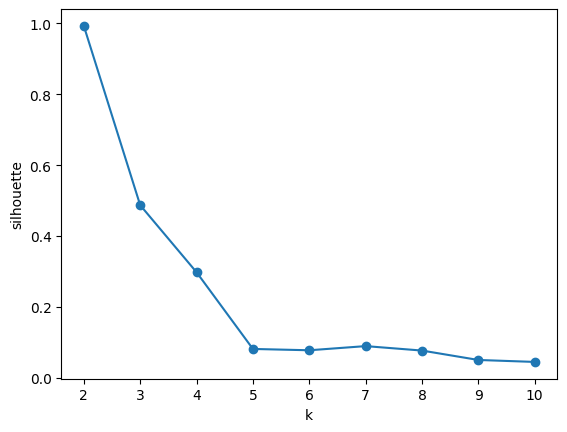

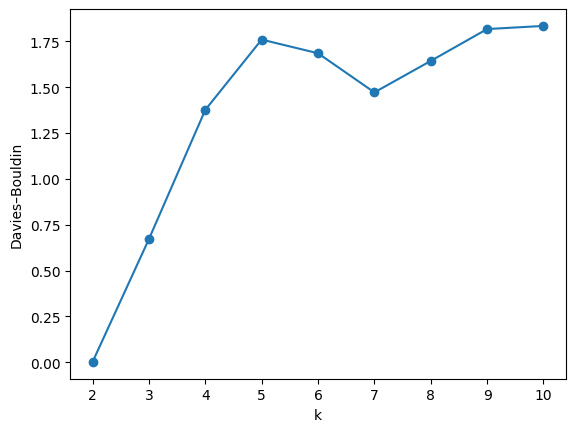

In [22]:
#test different number of k clusters
results = []
for k in range(2, 11):
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(clean_data)
  sil = silhouette_score(clean_data, labels)
  db  = davies_bouldin_score(clean_data, labels)
  results.append((k, sil, db))

results_df = pd.DataFrame(results, columns=["k","silhouette","davies_bouldin"])
display(results_df.sort_values("silhouette", ascending=False))

plt.figure(); plt.plot(results_df.k, results_df.silhouette, marker="o"); plt.xlabel("k"); plt.ylabel("silhouette"); plt.show()
plt.figure(); plt.plot(results_df.k, results_df.davies_bouldin, marker="o"); plt.xlabel("k"); plt.ylabel("Davies–Bouldin"); plt.show()

Clustering performance evaluated with silhouette score and Davies-Bouldin Index (DBI). Silhouette score tells us how clearly the clusters are separated (higher score means the groups are well-defined and different from each other). DBI tells us how similar the clusters are to each other (lower score means points within a cluster are similar to each other and that each cluster is clearly separated from each other).

Both evaluation metrics show two clusters (k=2) fit the data the best, indicating participants fall into two main CKD subgroups based on their clinical and biomarker patterns.

BUTTTTTTTT...

In [23]:
best_k = 2
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(clean_data)

df_clusters = df0.copy()
df_clusters["Cluster"] = cluster_labels
print(df_clusters["Cluster"].value_counts().sort_index())


Cluster
0    206
1      1
Name: count, dtype: int64


This is telling us there are 206 participants in one cluster and 1 in the the other....doesn't make sense. Could this be an outlier?

Analysis redone for potential outlier?:

,Sex,Age (Years),Race,Baseline eGFR (ml/min/1.73m2),Proteinuria (mg) (Binned),A1c (%) (Binned),Albuminuria (mg) (Binned),Diabetes History,Diabetes Duration (Years),Hypertension History,...,Potassium (mEq/L),Chloride (mEq/L),Calcium (mg/dL),Cystatin C (mg/L),Urine Creatinine (mg/dL),Urine Albumin (mg/dL),Urine Protein (mg/dL),ACR (mg/g),PCR (mg/g),Creatinine_Index_mgkgday
206,Male,60-69 Years,Black or African-American,30.46343,>=1000 mg/g cr,>=8.5%,>=1000 mg/g cr,Yes,20-24 Years,Yes,...,NaN,104.0,8.4,2.01,0.1,176.64,331.0,1808000.0,3310000.0,NaN


Removed 1 outlier participant(s). Remaining: 206


,k,silhouette,davies_bouldin
0,2,0.484004,0.978888
1,3,0.454017,1.170696
2,4,0.263501,1.298091
4,6,0.101053,1.645875
3,5,0.098198,1.862272
5,7,0.088397,1.711581
6,8,0.086324,1.697640
8,10,0.086127,1.588245
7,9,0.069968,1.821242


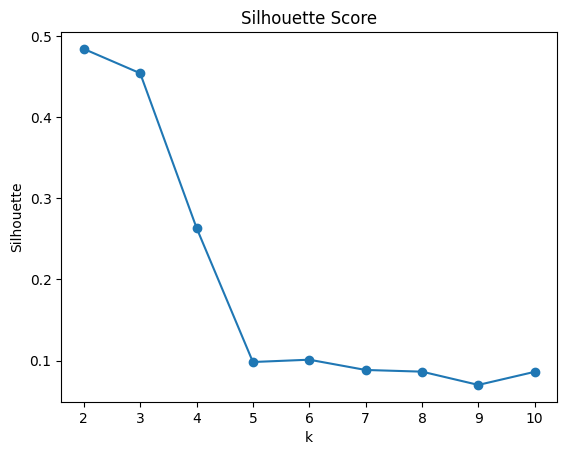

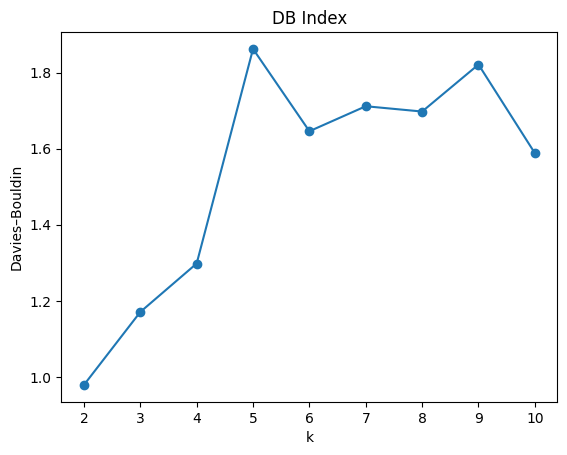

New cluster sizes:
 Cluster
0    192
1     14
Name: count, dtype: int64


In [24]:
#check for outlier participant
outlier_row = df0.loc[df_clusters["Cluster"] == 1]
display(outlier_row)

#remove participant
df_cleaned = df0.loc[df_clusters["Cluster"] != 1].copy()
print(f"Removed {len(outlier_row)} outlier participant(s). Remaining: {len(df_cleaned)}")

#redo preprocessing
clean_data2 = pre.fit_transform(df_cleaned)

#redo k means clustering
results = []
for k in range(2, 11):
  km = KMeans(n_clusters=k, n_init=30, random_state=42)
  labels = km.fit_predict(clean_data2)
  sil = silhouette_score(clean_data2, labels)
  db  = davies_bouldin_score(clean_data2, labels)
  results.append((k, sil, db))

results_df2 = pd.DataFrame(results, columns=["k","silhouette","davies_bouldin"])
display(results_df2.sort_values("silhouette", ascending=False))

plt.figure()
plt.plot(results_df2.k, results_df2.silhouette, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette Score")
plt.show()

plt.figure()
plt.plot(results_df2.k, results_df2.davies_bouldin, marker="o")
plt.xlabel("k"); plt.ylabel("Davies–Bouldin"); plt.title("DB Index")
plt.show()

#fit final model with new best k and check cluster sizes
best_k2 = int(results_df2.sort_values("silhouette", ascending=False).iloc[0]["k"])
final_kmeans2 = KMeans(n_clusters=best_k2, n_init=30, random_state=42)
labels2 = final_kmeans2.fit_predict(clean_data2)

df_clusters2 = df_cleaned.copy()
df_clusters2["Cluster"] = labels2
print("New cluster sizes:\n", df_clusters2["Cluster"].value_counts().sort_index())

Two cluster. One cluster has 192 and the other has 14 participants. Is this real data or due to other factors like biopsy collection, etc....

df_cluster2 : data we are working with now. Visualize the clusters

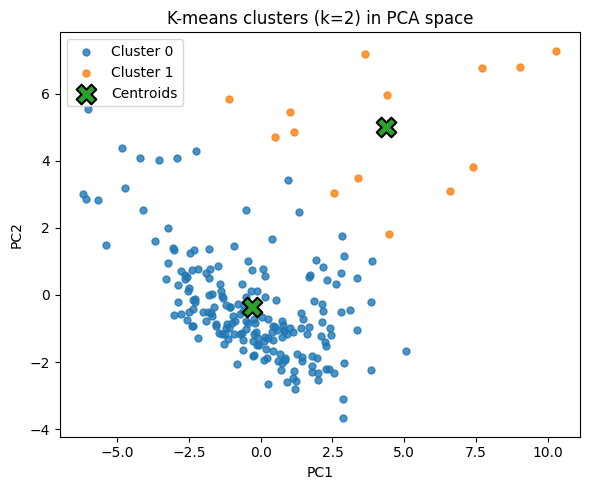

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# --- prepare data ---
df = df_clusters2.copy()
labels = df['Cluster'].astype(str)
X = df.drop(columns=['Cluster'], errors='ignore').select_dtypes(include=[np.number])
X = X.replace([np.inf, -np.inf], np.nan)  # guard against infinities

# --- pipeline: impute → scale → PCA(2) ---
pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    PCA(n_components=2, random_state=42)
)
Z = pipe.fit_transform(X)  # shape (n_samples, 2)

# --- plot ---
plt.figure(figsize=(6,5))
for lab in sorted(labels.unique()):
    idx = labels == lab
    plt.scatter(Z[idx, 0], Z[idx, 1], s=25, label=f"Cluster {lab}", alpha=0.8)

# centroids in PCA space
centroids = np.vstack([Z[labels == lab].mean(axis=0) for lab in sorted(labels.unique())])
plt.scatter(centroids[:,0], centroids[:,1], marker='X', s=200, edgecolors='k', linewidths=1.5, label='Centroids')

plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('K-means clusters (k=2) in PCA space')
plt.legend(); plt.tight_layout(); plt.show()


Explained variance ratio (PC1, PC2, PC3): [0.29922119 0.20116016 0.09191993]
Cumulative (3 PCs): 0.5923012752348445


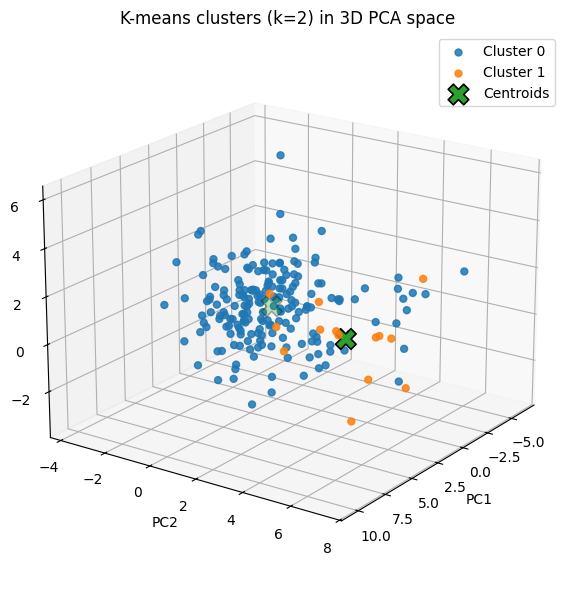

In [36]:
#3D PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- data prep ---
df = df_clusters2.copy()
labels = df['Cluster'].astype(str)
X = df.drop(columns=['Cluster'], errors='ignore')
X = X.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# --- pipeline: impute → scale → PCA(3) ---
pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    PCA(n_components=3, random_state=42)
)
Z = pipe.fit_transform(X)  # (n_samples, 3)
pca = pipe.named_steps['pca']
print("Explained variance ratio (PC1, PC2, PC3):", pca.explained_variance_ratio_)
print("Cumulative (3 PCs):", pca.explained_variance_ratio_.sum())

# --- 3D scatter by cluster ---
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

for lab in sorted(labels.unique()):
    idx = labels == lab
    ax.scatter(Z[idx, 0], Z[idx, 1], Z[idx, 2], s=25, alpha=0.85, label=f"Cluster {lab}")

# centroids in 3D PCA space
centroids = np.vstack([Z[labels == lab].mean(axis=0) for lab in sorted(labels.unique())])
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2],
           marker='X', s=220, edgecolors='k', linewidths=1.2, label='Centroids')

ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title('K-means clusters (k=2) in 3D PCA space')
ax.view_init(elev=20, azim=35)  # adjust view if needed
ax.legend()
plt.tight_layout()
plt.show()

In [37]:
#feature importance: t-test between the 2 clusters will test whether each feature differs significantly between clusters.

from scipy.stats import ttest_ind

features = df.drop(columns=['Cluster'], errors='ignore').select_dtypes(include=[np.number])
group1 = features[df['Cluster'] == 0]
group2 = features[df['Cluster'] == 1]

pvals = []
for col in features.columns:
    g1 = group1[col].dropna()
    g2 = group2[col].dropna()
    stat, p = ttest_ind(g1, g2, equal_var=False)
    pvals.append(p)

results = pd.DataFrame({'feature': features.columns, 'p_value': pvals})
results['-log10(p)'] = -np.log10(results['p_value'])
print(results.sort_values('p_value').head(10))

                    feature       p_value  -log10(p)
16    Urine Albumin (mg/dL)  3.111404e-07   6.507044
17    Urine Protein (mg/dL)  1.252591e-06   5.902191
18               ACR (mg/g)  2.610724e-06   5.583239
19               PCR (mg/g)  7.744498e-06   5.111007
4            Albumin (g/dL)  1.259951e-05   4.899647
13          Calcium (mg/dL)  2.854998e-05   4.544394
7   Total bilirubin (mg/dL)  5.024373e-05   4.298918
2                   eGFRCys  1.202015e-02   1.920090
14        Cystatin C (mg/L)  4.399247e-02   1.356622
3                 eGFRCrCys  1.080827e-01   0.966244


In [ ]:
#find which cluster has a higher value of which feature

df = df_clusters2.copy()

# numeric features only
features = df.drop(columns=['Cluster'], errors='ignore').select_dtypes(include=[np.number])
group1 = features[df['Cluster'] == 0]
group2 = features[df['Cluster'] == 1]

pvals, mean0, mean1 = [], [], []

for col in features.columns:
    g1 = group1[col].dropna()
    g2 = group2[col].dropna()
    stat, p = ttest_ind(g1, g2, equal_var=False)
    pvals.append(p)
    mean0.append(g1.mean())
    mean1.append(g2.mean())

results = pd.DataFrame({
    'feature': features.columns,
    'Cluster0_mean': mean0,
    'Cluster1_mean': mean1,
    'p_value': pvals
})
results['-log10(p)'] = -np.log10(results['p_value'])
results['Higher_in'] = np.where(results['Cluster0_mean'] > results['Cluster1_mean'],
                                'Cluster 0', 'Cluster 1')

results = results.sort_values('p_value')
print(results.head(10))


                    feature  Cluster0_mean  Cluster1_mean       p_value  \
16    Urine Albumin (mg/dL)      22.026702     261.381429  3.111404e-07   
17    Urine Protein (mg/dL)      38.434555     403.142857  1.252591e-06   
18               ACR (mg/g)     390.179166    4973.169342  2.610724e-06   
19               PCR (mg/g)     655.811816    7669.824562  7.744498e-06   
4            Albumin (g/dL)       4.231571       3.335714  1.259951e-05   
13          Calcium (mg/dL)       9.519105       8.685714  2.854998e-05   
7   Total bilirubin (mg/dL)       0.471204       0.307143  5.024373e-05   
2                   eGFRCys      47.797885      36.599747  1.202015e-02   
14        Cystatin C (mg/L)       1.564069       1.925380  4.399247e-02   
3                 eGFRCrCys      51.369307      42.617317  1.080827e-01   

    -log10(p)  Higher_in  
16   6.507044  Cluster 1  
17   5.902191  Cluster 1  
18   5.583239  Cluster 1  
19   5.111007  Cluster 1  
4    4.899647  Cluster 0  
13   4.54439

In [40]:
results.to_excel("~/Documents/BINF/competition/cluster_feature_differences.xlsx", index=False)